In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rc('font', size=16)
mpl.rc('figure', figsize=(8, 6))

# Model

Operator `initdamp` ran in 0.01 s


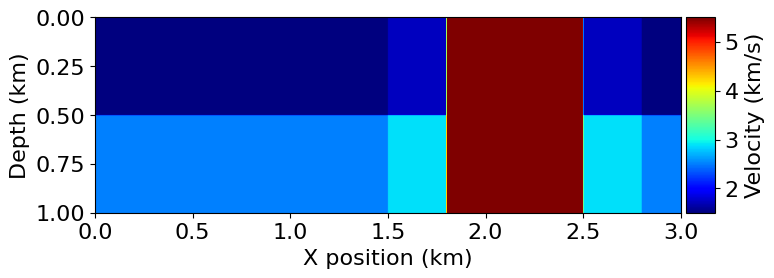

In [2]:
from examples.seismic import Model, plot_velocity

# Define a physical size
shape = (3001, 1001)  # Number of grid point (nx, nz)
spacing = (1., 1.)  # Grid spacing in m
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :501] = 1.5
v[:, 501:] = 2.5
v[1800:2500, :] = 5.5

# Define Precursor
v[1500:1800, :501] = 1.5*1.15
v[1500:1800, 501:] = 2.5*1.15
v[2500:2800, :501] = 1.5*1.15
v[2500:2800, 501:] = 2.5*1.15




# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=20, bcs="damp")

plot_velocity(model)

In [3]:
v

array([[1.5, 1.5, 1.5, ..., 2.5, 2.5, 2.5],
       [1.5, 1.5, 1.5, ..., 2.5, 2.5, 2.5],
       [1.5, 1.5, 1.5, ..., 2.5, 2.5, 2.5],
       ...,
       [1.5, 1.5, 1.5, ..., 2.5, 2.5, 2.5],
       [1.5, 1.5, 1.5, ..., 2.5, 2.5, 2.5],
       [1.5, 1.5, 1.5, ..., 2.5, 2.5, 2.5]], dtype=float32)

Время

In [4]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 400.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt * 0.5  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

Источники

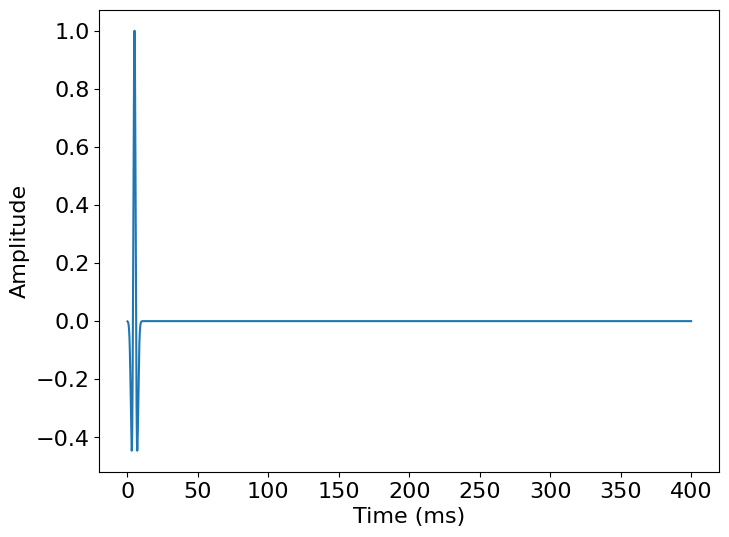

In [5]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.200  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .45
src.coordinates.data[0, -1] = 300.  # Depth is 20m

# We can plot the time signature to see the wavelet
src.show()

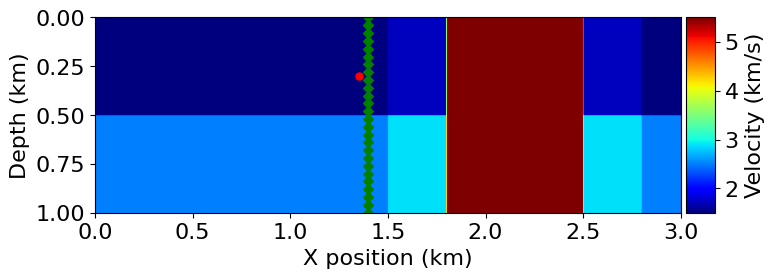

In [6]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 1] = np.linspace(0, model.domain_size[1], num=101)
rec.coordinates.data[:, 0] =  model.domain_size[0] * .45 + 50

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

In [7]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=3, space_order=3)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde

damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [8]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))
stencil

Eq(u(t + dt, x, y), (-(-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + 0.5*damp(x, y)*u(t - dt, x, y)/dt)/(0.5*damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [9]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

In [10]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

In [11]:
#NBVAL_IGNORE_OUTPUT
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 23.50 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=23.480493000000045, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0027310000000000372, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.010350999999999876, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [12]:
#NBVAL_IGNORE_OUTPUT
# from examples.seismic import plot_shotrecord

# plot_shotrecord(rec.data, model, t0, tn)

In [13]:
model.domain_size

(np.float32(3000.0), np.float32(1000.0))

In [14]:
def plot_shotrecord(rec, model, t0, tn, colorbar=True):
    """
    Plot a shot record (receiver values over time).

    Parameters
    ----------
    rec :
        Receiver data with shape (time, points).
    model : Model
        object that holds the velocity model.
    t0 : int
        Start of time dimension to plot.
    tn : int
        End of time dimension to plot.
    """
    scale = np.max(rec) / 10.
    extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[1],
              1e-3*tn, t0]

    plot = plt.imshow(rec, vmin=-scale, vmax=scale, cmap=cm.gray, extent=extent)
    plt.xlabel('Depth (km)')
    plt.ylabel('Time (s)')

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(plot, cax=cax)
    plt.savefig('Results/2d_test_(ST-order-3)', dpi=500)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/spaceswimmer/Documents/NeoGen_Modeling/Test_code/Results/2d_test_(ST-order-3).png'

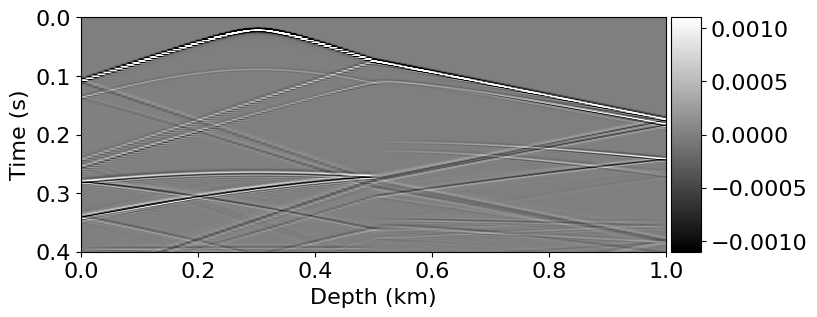

In [15]:
plot_shotrecord(rec.data, model, t0, tn)